In [1]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

In [2]:
# Automatically restart kernel after installs
#import IPython
#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)

In [3]:
PROJECT_ID = 'wide-dryad-334006' # Change to your project.
REGION = 'US'

In [4]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, 
                                 timestamp_col_name, 
                                 data_col_name, 
                                 forecast_output=None, 
                                 actual=None, 
                                 title=None,
                                 plotstartdate=None):

    if plotstartdate:
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]
    input_timeseries = input_timeseries.sort_values(timestamp_col_name)    
    
    # Plot the input historical data
    plt.figure(figsize=(20,6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

    # Display title, legend
    plt.title(f'{title}', fontsize= 16)
    plt.legend(loc = 'upper center', prop={'size': 16})

In [6]:
!bq mk --location=$REGION --dataset $PROJECT_ID:bqmlforecast

BigQuery error in mk operation: Dataset 'wide-dryad-334006:bqmlforecast' already
exists.


In [7]:
%load_ext google.cloud.bigquery

In [8]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/Users/Futurense/Desktop/materials/gcp/bigml.json"

In [9]:
!pip install pyarrow

In [10]:
%%bigquery --project $PROJECT_ID

SELECT 
    invoice_and_item_number,
    date,
    store_number,
    item_description,
    bottles_sold,
    sale_dollars
FROM
  `bigquery-public-data.iowa_liquor_sales.sales` 
LIMIT 
  5

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35rows/s]


,invoice_and_item_number,date,store_number,item_description,bottles_sold,sale_dollars
0,INV-37062400001,2021-06-01,3773,Ardbeg Wee Beastie,30,1012.200
1,INV-23645000007,2019-12-03,5866,Templeton 4YR Rye,2,63.000
2,INV-31180200030,2020-10-20,4203,Dr. Mcgillicuddy''s Grape Football PET Mini,3,22.500
3,INV-31222700013,2020-10-21,3990,Paramount Sloe Gin,2,16.260
4,S18858500080,2014-05-08,3692,Montezuma Triple Sec,48,153.120


## Set the start and end dates for the training data

In [11]:
ARIMA_PARAMS = {
    'TRAININGDATA_STARTDATE': '2016-01-01',
    'TRAININGDATA_ENDDATE': '2017-06-01',
}
ARIMA_PARAMS

{'TRAININGDATA_STARTDATE': '2016-01-01', 'TRAININGDATA_ENDDATE': '2017-06-01'}

## Write the training data to a table

In [12]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE TABLE bqmlforecast.training_data AS (
    WITH topsellingitems AS(
         SELECT 
            item_description,
            count(item_description) cnt_transactions
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales` 
        GROUP BY 
            item_description
        ORDER BY cnt_transactions DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales` 
    GROUP BY
        date, item_name
    HAVING 
        date BETWEEN @TRAININGDATA_STARTDATE AND @TRAININGDATA_ENDDATE
        AND item_description IN (SELECT item_description FROM topsellingitems)
    );

SELECT 
    date,
    item_name,
    total_amount_sold
FROM 
    bqmlforecast.training_data 
ORDER BY item_name, date
LIMIT 10

Downloading: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.43rows/s]


,date,item_name,total_amount_sold
0,2016-01-04,Black Velvet,5014
1,2016-01-05,Black Velvet,5193
2,2016-01-06,Black Velvet,4422
3,2016-01-07,Black Velvet,3760
4,2016-01-11,Black Velvet,4492
5,2016-01-12,Black Velvet,4945
6,2016-01-13,Black Velvet,4302
7,2016-01-14,Black Velvet,3394
8,2016-01-15,Black Velvet,2318
9,2016-01-19,Black Velvet,4714


## Plot the sales histories of the target liquor products

In [13]:
%%bigquery dfhistorical --project $PROJECT_ID 

SELECT 
    * 
FROM 
    bqmlforecast.training_data

Downloading: 100%|██████████████████████████████████████████████████████████████| 1692/1692 [00:02<00:00, 608.30rows/s]


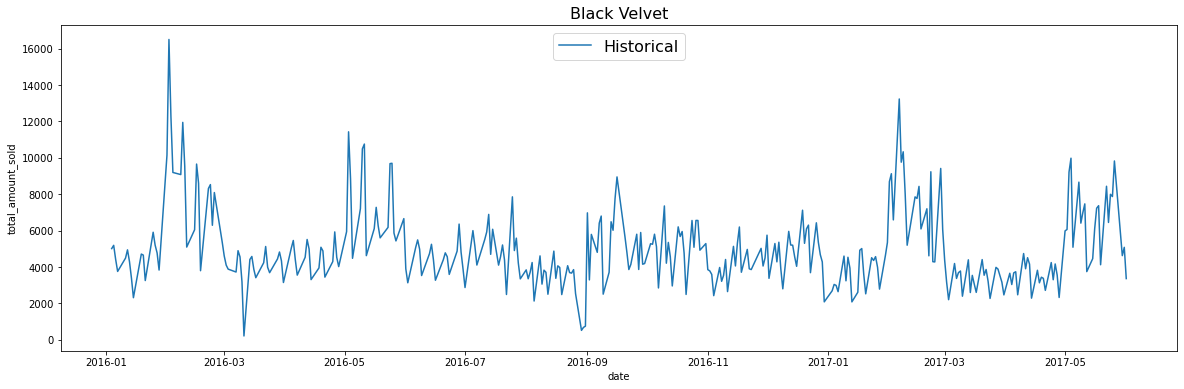

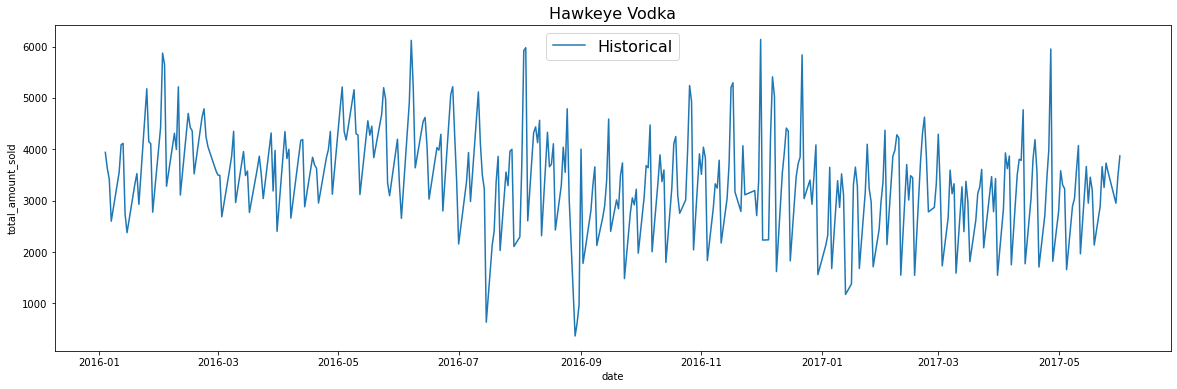

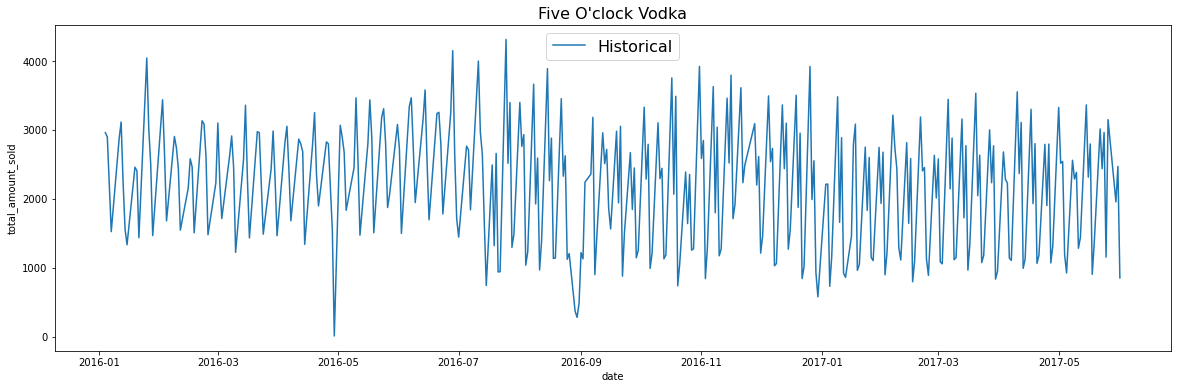

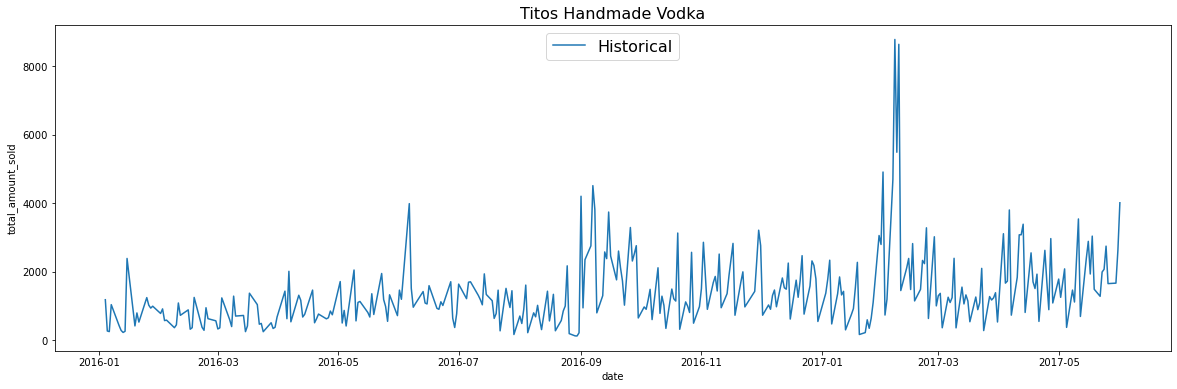

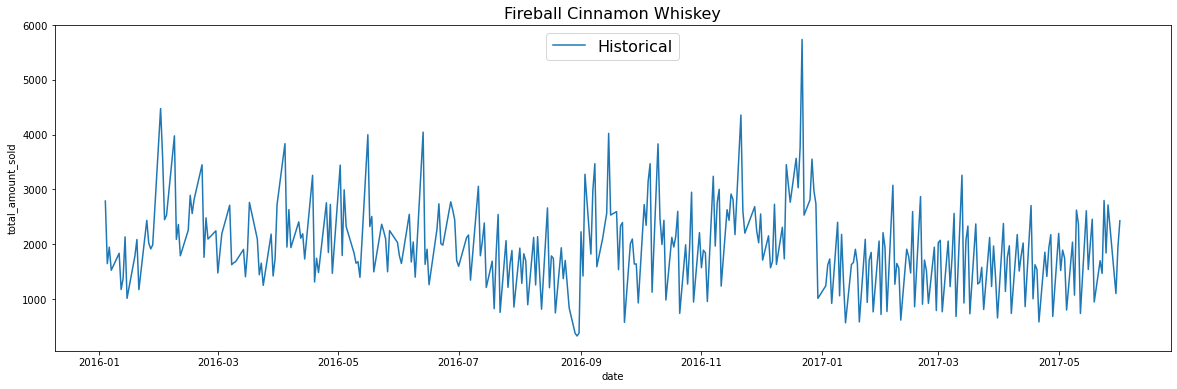

In [14]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    
    datah = dfhistorical[dfhistorical.item_name==item]
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = None, 
                                 actual = None,
                                 title = item)

## Train the model

In [15]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE MODEL bqmlforecast.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL='item_name',
  HOLIDAY_REGION='US'
) AS

SELECT 
    date,
    item_name,
    total_amount_sold
FROM
  bqmlforecast.training_data

Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 3029.11query/s]


""


## Evaluate

In [16]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlforecast.arima_model)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75rows/s]


,item_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,Black Velvet,3,1,2,False,-4132.346,8276.691,562466.115,[WEEKLY]
1,Fireball Cinnamon Whiskey,2,1,1,True,-3683.019,7376.037,97168.305,[WEEKLY]
2,Five O'clock Vodka,4,0,1,False,-3491.474,6996.948,8757.842,[WEEKLY]
3,Hawkeye Vodka,2,1,2,False,-3785.002,7580.004,145425.326,[WEEKLY]
4,Titos Handmade Vodka,0,1,5,False,-3807.245,7626.489,157343.325,[WEEKLY]


## Make predictions using the model

In [17]:
%%bigquery dfforecast --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL bqmlforecast.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)

Downloading: 100%|█████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 39.92rows/s]


In [18]:
dfforecast.head()

,item_name,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,Black Velvet,2017-06-02 00:00:00+00:00,1404.775,749.977,0.900,172.509,2637.042,172.509,2637.042
1,Black Velvet,2017-06-03 00:00:00+00:00,2013.170,971.562,0.900,416.824,3609.516,416.824,3609.516
2,Black Velvet,2017-06-04 00:00:00+00:00,3213.622,1177.028,0.900,1279.681,5147.562,1279.681,5147.562
3,Black Velvet,2017-06-05 00:00:00+00:00,3573.866,1281.806,0.900,1467.767,5679.964,1467.767,5679.964
4,Black Velvet,2017-06-06 00:00:00+00:00,2257.318,1391.810,0.900,-29.524,4544.161,-29.524,4544.161


In [19]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 150


## Inspect the model coefficients

In [20]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL bqmlforecast.arima_model)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32rows/s]


,item_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,Black Velvet,"[-0.16549655445723319, -0.7477843111888047, -0...","[-0.010971872002911037, 0.7809755718652553]",0.000
1,Fireball Cinnamon Whiskey,"[0.5099256868357989, 0.17365890632425174]",[-0.9999915981003452],-2.764
2,Five O'clock Vodka,"[-0.3596844148293946, 0.6178849330746929, 0.15...",[0.8837349172639454],2129.972
3,Hawkeye Vodka,"[-0.20942045212532412, 0.6765204517126348]","[-0.08520133108699894, -0.8556243195314104]",0.000
4,Titos Handmade Vodka,[],"[-0.2597486052415876, 0.1442453510061992, -0.5...",0.000


## Plot the forecasted predictions against the historical data

C:\Users\Futurense\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\Futurense\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\Futurense\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered n

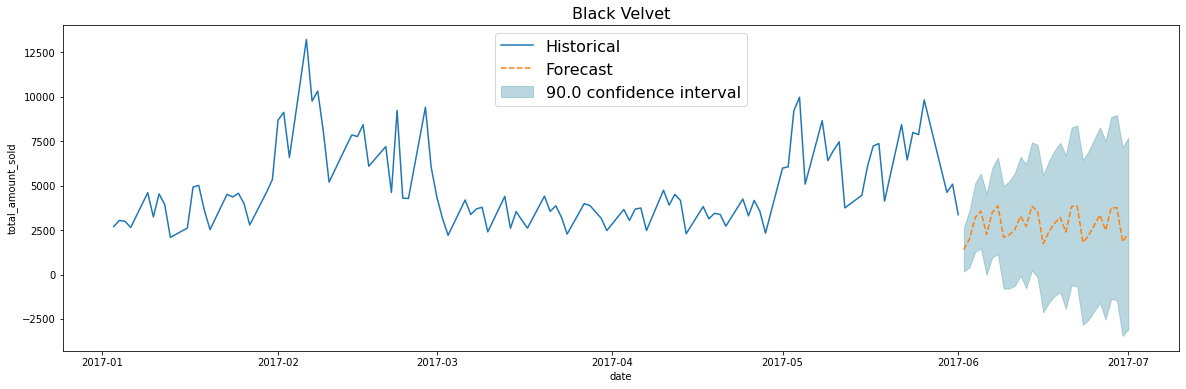

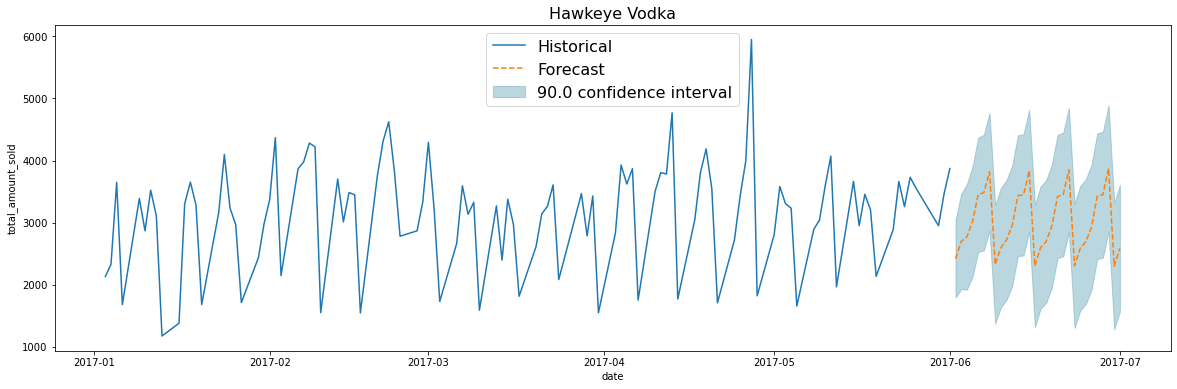

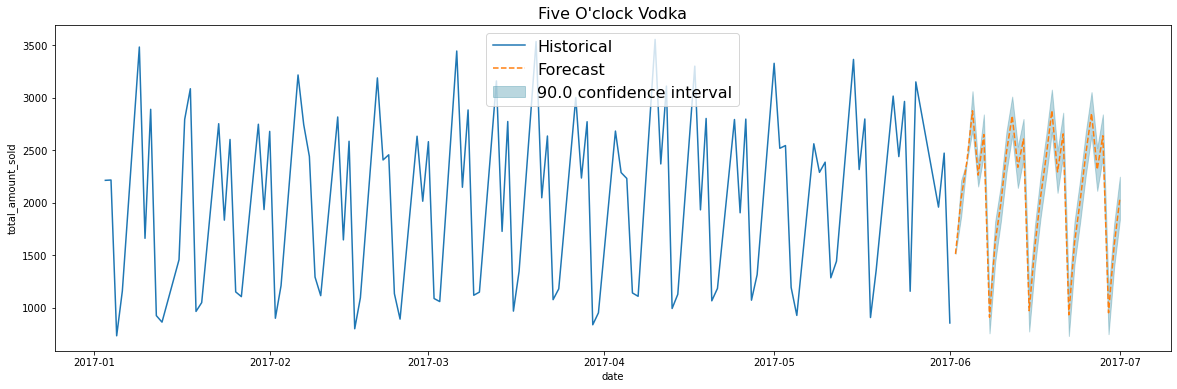

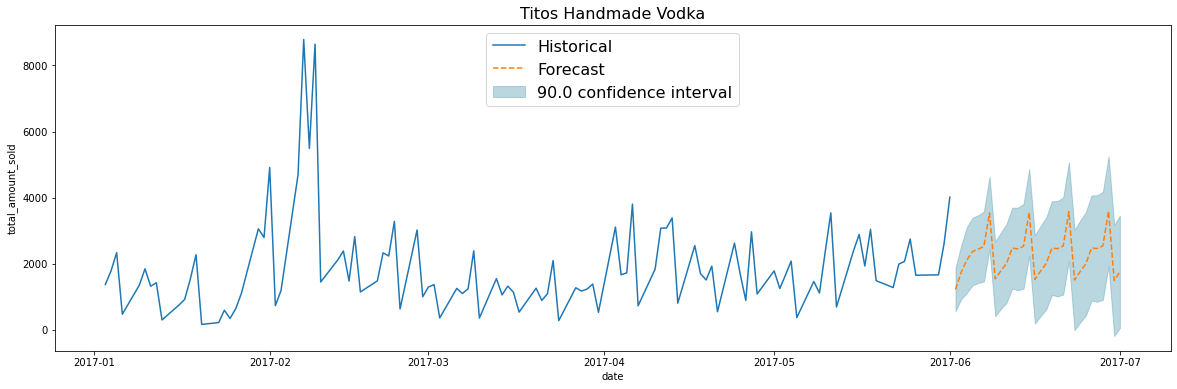

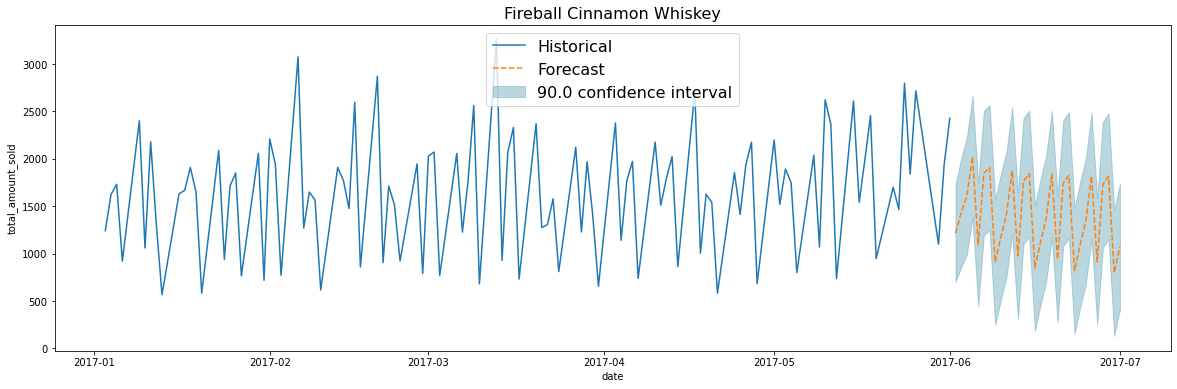

In [21]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item]
    dataf = dfforecast[dfforecast.item_name==item]
    
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = dataf, 
                                 actual = None,
                                 title = item,
                                 plotstartdate = "2017-01-01")

#### At 90% confidence interval , after using AUTO ARIMA, considering both historical and forecast values.

## Plot the forecasted predictions against the actual data

In [22]:
%%bigquery dfactual --params $ARIMA_PARAMS --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast

SELECT 
    date,
    item_description AS item_name,
    SUM(bottles_sold) AS total_amount_sold
FROM
    `bigquery-public-data.iowa_liquor_sales.sales` 
GROUP BY
    date, item_name
HAVING 
    date BETWEEN DATE_ADD(@TRAININGDATA_ENDDATE, 
                              INTERVAL 1 DAY) 
            AND DATE_ADD(@TRAININGDATA_ENDDATE, 
                             INTERVAL 1+CAST(HORIZON AS INT64) DAY) 
ORDER BY
    date;

Downloading: 100%|███████████████████████████████████████████████████████████| 21264/21264 [00:03<00:00, 5912.72rows/s]


In [23]:
dfactual.head()

,date,item_name,total_amount_sold
0,2017-06-02,Juarez Triple Sec,664
1,2017-06-02,Bacardi Gold Rum,183
2,2017-06-02,Everclear Alcohol,71
3,2017-06-02,Cedar Ridge Dark Rum,6
4,2017-06-02,Kahlua Coffee Liqueur,27


C:\Users\Futurense\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\Futurense\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\Futurense\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered n

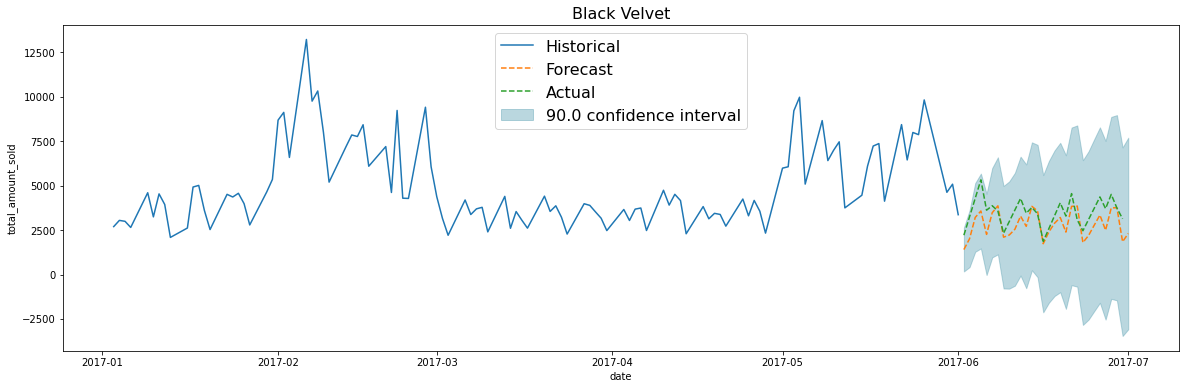

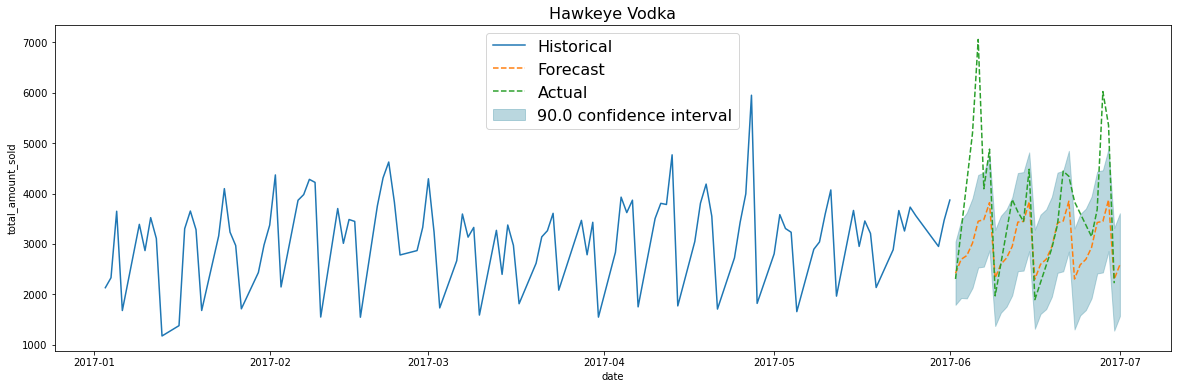

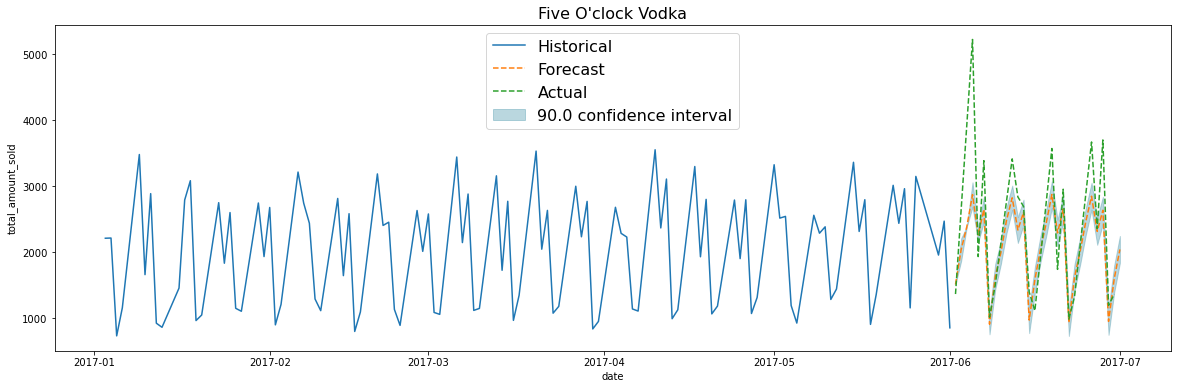

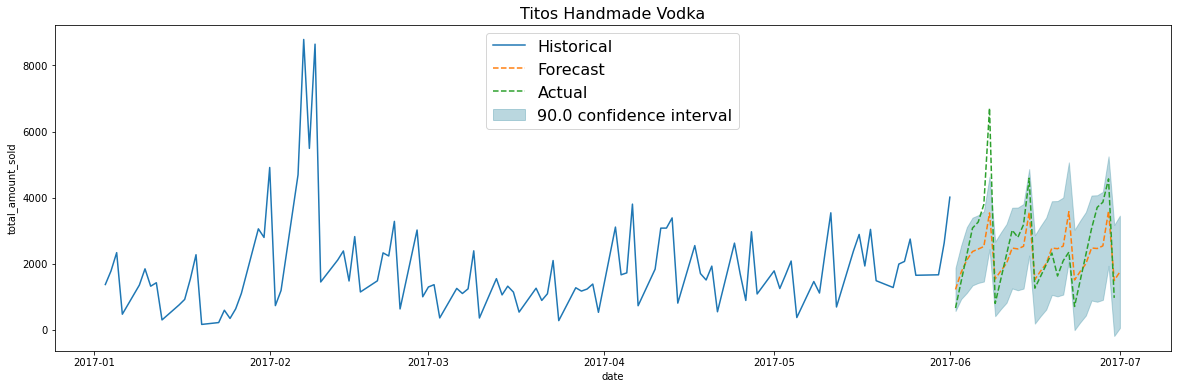

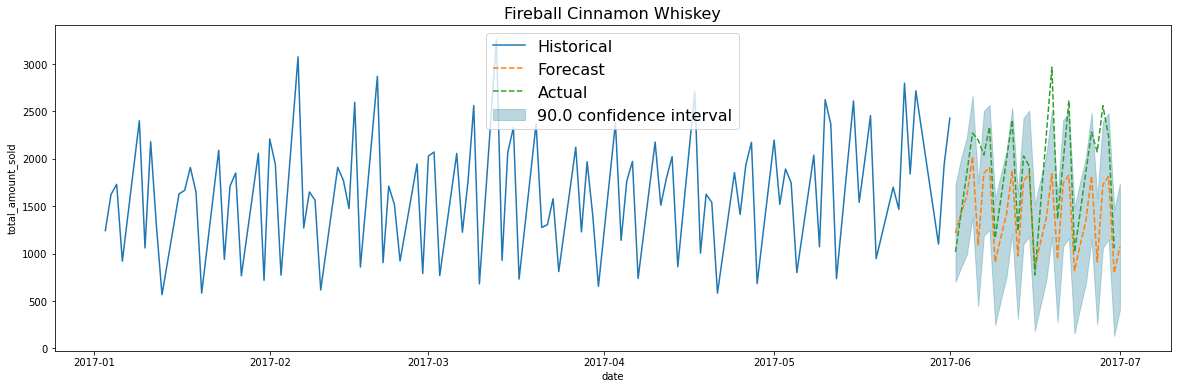

In [24]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item].sort_values('date')
    dataf = dfforecast[dfforecast.item_name==item].sort_values(['forecast_timestamp'])
    dataa = dfactual[dfactual.item_name==item].sort_values('date')
    plot_historical_and_forecast(input_timeseries = datah, 
                             timestamp_col_name = "date", 
                             data_col_name = "total_amount_sold", 
                             forecast_output = dataf, 
                             actual = dataa,
                             title = item,
                             plotstartdate = "2017-01-01")

# Create a dashboard with Data Studio

## Create a view containing the data for the dashboard

In [25]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlforecast.outputdata_datastudio AS (
  SELECT
    date AS timestamp,
    item_name,
    total_amount_sold AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
    bqmlforecast.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    item_name,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL bqmlforecast.arima_model,
      STRUCT(30 AS horizon, 0.9 AS confidence_level)) 
  ORDER BY timestamp
  )

Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 991.09query/s]


""
